# Importando o que importa (haha)

In [1]:
from freeSpace import *
from collections import defaultdict
import numpy as np
import math
import pandas as pd
from geopy.distance import vincenty
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from geopy.distance import great_circle
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

from scipy.interpolate import griddata

# Pegando os Valores de Treinamento

In [2]:
#Erbs
csvErbs = pd.read_csv("erbs.csv")
erbsLidas = csvErbs[['lat','lon']].values
erbs_posicao = dict()
for i in range (1,len(erbsLidas)+1):
    erbs_posicao[i] = (erbsLidas[i-1])

#Medicoes, dados de treinamento
csvMed = pd.read_csv("medicoes.csv")
medidas_posicao = csvMed[['lat','lon']].values # Valores em Tupla
medidas_potencia = csvMed[["RSSI_1","RSSI_2","RSSI_3","RSSI_4","RSSI_5","RSSI_6"]].values




# Interpolacao e criacao de pontos do grid

In [3]:

#ver link https://docs.scipy.org/doc/scipy/reference/interpolate.html
#ver link https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html
resolucao = 40 #valor referente a resolucao do grid. OBS: nao tem relacao com metros
#o grid so aceita valores positivos para os pontos
#intervalos do grid
lat_in = 8.08
lat_fim = 8.0605
lon_in = 34.91
lon_fim = 34.887


desloc_lat = (lat_in - lat_fim)/resolucao #valor correspondente ao deslocamento em latitude das celulas do grid, positivo
desloc_lon = (lon_in - lon_fim)/resolucao #valor correspondente ao deslocamento em longitude das celulas do grid

#construcao do grid
grid_lat, grid_lon = np.mgrid[lat_fim:lat_in:desloc_lat, lon_fim:lon_in:desloc_lon] 
np.shape(grid_lat)
#grid_lon

(40, 40)

In [4]:

#pegando pontos conhecidos para regressao, uma para cada erb
pontos_teste = -medidas_posicao #o grid so aceita coordenadas positivas
medidas_ref_erb1 = medidas_potencia[:,0] #medidas de ref para ajuste do modelo de regressao
medidas_ref_erb2 = medidas_potencia[:,1]
medidas_ref_erb3 = medidas_potencia[:,2]
medidas_ref_erb4 = medidas_potencia[:,3]
medidas_ref_erb5 = medidas_potencia[:,4]
medidas_ref_erb6 = medidas_potencia[:,5]

#grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
#interpolacao, considerada de foma independente para cada erb
grid_z1 = griddata(pontos_teste, medidas_ref_erb1, (grid_lat, grid_lon), method='linear')
grid_z2 = griddata(pontos_teste, medidas_ref_erb2, (grid_lat, grid_lon), method='linear')
grid_z3 = griddata(pontos_teste, medidas_ref_erb3, (grid_lat, grid_lon), method='linear')
grid_z4 = griddata(pontos_teste, medidas_ref_erb4, (grid_lat, grid_lon), method='linear')
grid_z5 = griddata(pontos_teste, medidas_ref_erb5, (grid_lat, grid_lon), method='linear')
grid_z6 = griddata(pontos_teste, medidas_ref_erb6, (grid_lat, grid_lon), method='linear')
#np.shape(medidas_teste)
np.shape(grid_z1)
#grid_z1[0:10][0:10]
#grid_z1

(40, 40)

In [35]:
(grid_lat[9][26], grid_lon[9][26])

(8.0648874999999993, 34.901949999999999)

In [60]:
not(math.isnan(grid_z1[0][0]))

False

In [5]:

#adicionar dados validos obtidos da interpolacao para a base de dados do knn, criando um novo dataframe

#criar lista para receber novas coordenadas
coord_interpol = []
coord_interpol

for i in range(resolucao):
    for j in range(resolucao):
        if not(math.isnan(grid_z1[i][j])) and not(math.isnan(grid_z2[i][j])) and not(math.isnan(grid_z3[i][j])) and not(math.isnan(grid_z4[i][j])) and not(math.isnan(grid_z5[i][j])) and not(math.isnan(grid_z6[i][j])):  
            coord_interpol.append([-grid_lat[i][j] ,-grid_lon[i][j],grid_z1[i][j], grid_z2[i][j], grid_z3[i][j], grid_z4[i][j], grid_z5[i][j], grid_z6[i][j]])
        


In [7]:

#np.shape(coord_interpol)
#type(coord_interpol)


#criar dataframe e concatenar com os dados da base do knn
dados_iterpol = pd.DataFrame(coord_interpol,columns=['lat','lon','RSSI_1','RSSI_2','RSSI_3','RSSI_4','RSSI_5','RSSI_6'])
csvMed = pd.concat([csvMed, dados_iterpol])

In [8]:
np.shape(coord_interpol)

(761, 8)

In [9]:
csvMed

,lat,lon,RSSI_1,RSSI_2,RSSI_3,RSSI_4,RSSI_5,RSSI_6
0,-8.077546,-34.899288,-66.825000,-35.600000,-64.875000,-72.575000,-79.525000,-78.450000
1,-8.077545,-34.899265,-66.200000,-33.650000,-71.050000,-71.750000,-71.400000,-84.550000
2,-8.077541,-34.899246,-68.225000,-32.300000,-66.475000,-71.150000,-79.500000,-83.000000
3,-8.077541,-34.899231,-67.333333,-28.933333,-64.933333,-70.266667,-77.500000,-80.400000
4,-8.077540,-34.899231,-64.600000,-26.300000,-62.233333,-68.700000,-73.100000,-82.366667
5,-8.077540,-34.899223,-67.450000,-27.800000,-59.450000,-66.450000,-76.400000,-81.200000
6,-8.077538,-34.899307,-66.700000,-44.466667,-62.333333,-79.433333,-77.900000,-81.500000
7,-8.077538,-34.899231,-60.506977,-28.869767,-62.634884,-68.532558,-72.676744,-83.309302
8,-8.077533,-34.899204,-67.133333,-26.866667,-62.300000,-66.566667,-76.566667,-80.833333
9,-8.077438,-34.898800,-57.766667,-22.966667,-67.266667,-63.166667,-71.233333,-80.300000


# Gera Modelo 

In [37]:
#medidas_potencia.values
medidas_posicao_lat = csvMed['lat'].values
medidas_posicao_lon = csvMed['lon'].values

medidas_potencia = csvMed[["RSSI_1","RSSI_2","RSSI_3","RSSI_4","RSSI_5","RSSI_6"]].values




#modela latitude e longitude separadamente
neigh_lat = KNeighborsRegressor(n_neighbors=10, weights = 'distance')
neigh_lat.fit(medidas_potencia,medidas_posicao_lat )

neigh_lon = KNeighborsRegressor(n_neighbors=10, weights = 'distance')
neigh_lon.fit(medidas_potencia,medidas_posicao_lon )



KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='distance')

In [38]:
medidas_potencia[0:5]

array([[-66.825     , -35.6       , -64.875     , -72.575     ,
        -79.525     , -78.45      ],
       [-66.2       , -33.65      , -71.05      , -71.75      ,
        -71.4       , -84.55      ],
       [-68.225     , -32.3       , -66.475     , -71.15      ,
        -79.5       , -83.        ],
       [-67.33333333, -28.93333333, -64.93333333, -70.26666667,
        -77.5       , -80.4       ],
       [-64.6       , -26.3       , -62.23333333, -68.7       ,
        -73.1       , -82.36666667]])

# Pega os Valores de Teste

In [39]:

csvMedTest = pd.read_csv("testLoc.csv")
medidas_posicao_teste = csvMedTest[['lat','lon']].values # Valores em Tupla
medidas_potencia_teste = csvMedTest[["RSSI_1","RSSI_2","RSSI_3","RSSI_4","RSSI_5","RSSI_6"]].values    


In [13]:
np.shape(medidas_posicao_teste)

(200, 2)

# Faz a Predição

In [40]:
predicao_lat = neigh_lat.predict(medidas_potencia_teste)
predicao_lon = neigh_lon.predict(medidas_potencia_teste)

# Calcula o Erro

In [41]:
vet_err_lat = []
vet_err_lon = []
for i in range(0,200):
    vet_err_lat.append(predicao_lat[i] - medidas_posicao_teste[i][0])
    vet_err_lon.append(predicao_lon[i] - medidas_posicao_teste[i][1])

err_geral = []
for i in range(len(predicao_lat)):
    err_geral.append(vincenty((predicao_lat[i],predicao_lon[i]), (medidas_posicao_teste[i][0], medidas_posicao_teste[i][1])).kilometers)



In [42]:
print("MEDIA LAT = " + str(np.mean(vet_err_lat)))
print("MEDIA LON = " + str(np.mean(vet_err_lon)))
print("MEDIA KM = " + str(np.mean(err_geral)))
print("STD = " + str(np.std(err_geral)))


MEDIA LAT = -3.44802649896e-05
MEDIA LON = 0.00114729449955
MEDIA KM = 0.190406778261
STD = 0.364721661374


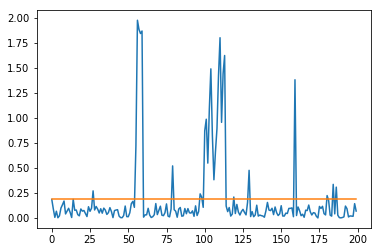

In [17]:
plt.plot(range(200),err_geral, range(200),[np.mean(err_geral)for i in range(200)])
plt.show()

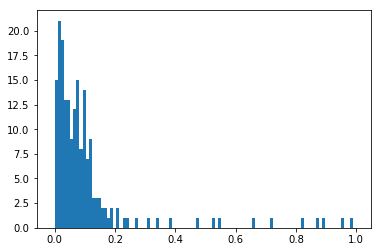

In [18]:
plt.clf()
bins = np.linspace(-0.01, 1, 100)
plt.hist(err_geral,bins)
plt.show()

In [57]:
X = medidas_posicao_lat

In [58]:
Y = medidas_posicao_lon

In [59]:
rssi1 = csvMed["RSSI_1"].values
Z = rssi1

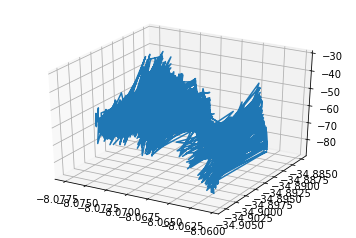

In [71]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X,Y,Z)
plt.show()

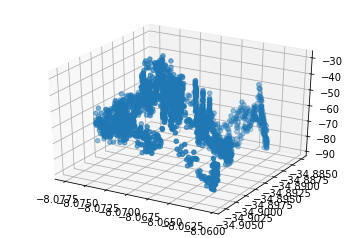

In [69]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z)
plt.show()

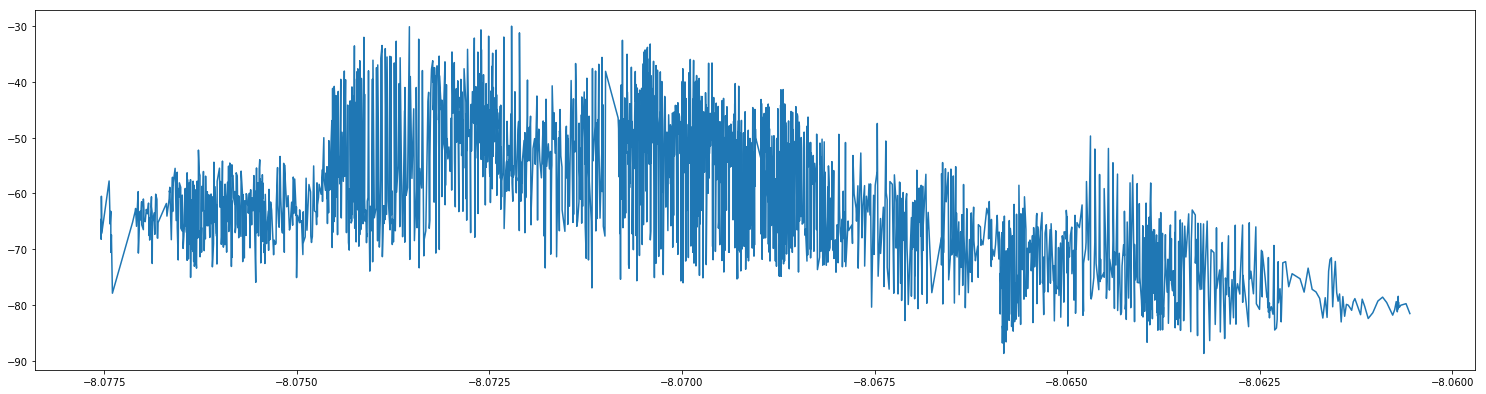

In [77]:
plt.clf()
fig = plt.figure(figsize=(20,5))
axes = fig.add_axes([0.1,0.1,1,1])
plt.plot(X,Z,X,)
plt.show()

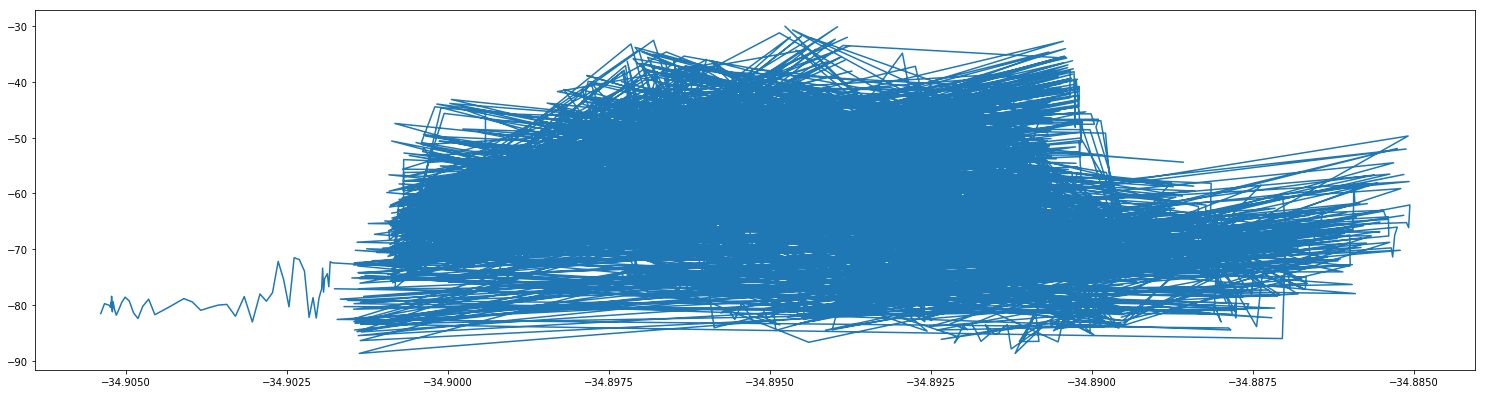

In [78]:
plt.clf()
fig = plt.figure(figsize=(20,5))
axes = fig.add_axes([0.1,0.1,1,1])
plt.plot(Y,Z)
plt.show()

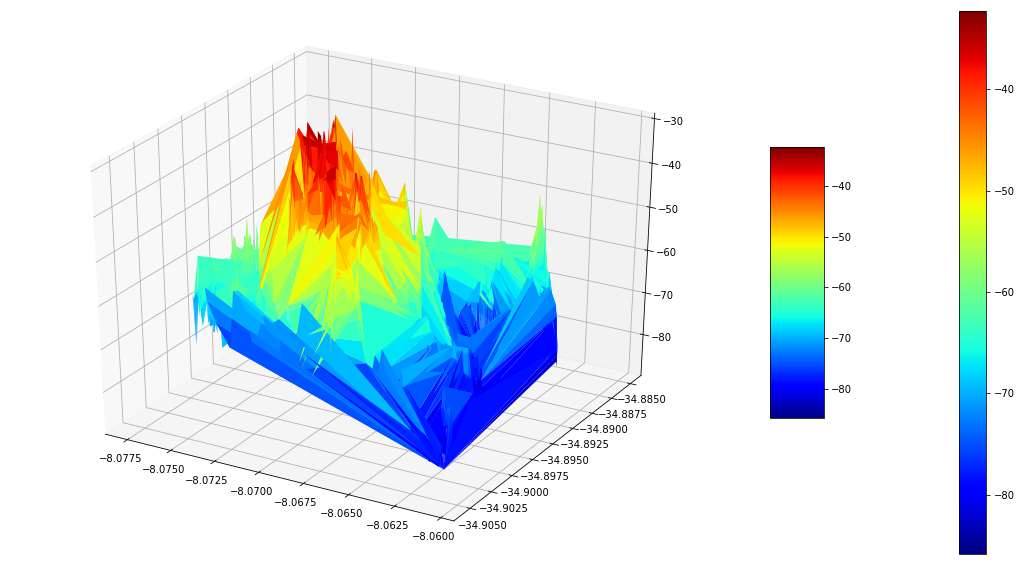

In [82]:
plt.clf()
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(X, Y, Z, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()